In [2]:
!pip install -r requirements.txt

  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached torch-2.5.1-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
  Using cached tqdm-4.66.6-py3-none-any.whl.metadata (57 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylin

# Pytroch autodiff example

In [1]:
import torch

x = torch.tensor(5.0, requires_grad=True)
f = 2 * (x ** 2) + 5
gr, = torch.autograd.grad(f, x)
print(gr)  # This will print the derivative of f with respect to x

tensor(20.)


# Wolfram Alpha

maybe I should have used a unit package but I havent used one before

kcal/(g * Å) in Å/(ps²) wolfram says: <br>
https://www.wolframalpha.com/input?i=convert+kcal%2F%28g+*+Å%29+in+Å%2F%28ps²%29 <br>

418.4 Å/ps^2 (ångströms per picosecond squared) <br>

Boltzmann constant: <br>
https://www.wolframalpha.com/input?i=boltzmann+constant <br>
1.381×10^-23 J/K (joules per kelvin)

The joule from the kinetic energy: <br>
[g * Å^2 / (ps^2 * mol) to  joule](https://www.wolframalpha.com/input?i=Unit+Conversions&assumption=%7B"F"%2C+"UnitsConversion"%2C+"toUnit"%7D+->"joule"&assumption=%7B"C"%2C+"Unit+Conversions"%7D+->+%7B"Calculator"%2C+"dflt"%7D&assumption=%7B"F"%2C+"UnitsConversion"%2C+"fromUnit"%7D+->"g+*+Å%5E2+%2F+%28ps%5E2+*+mol%29") <br> 
1.661×10^-23 J (joules) <br>

From g *Å^2/(ps^2 * mol) to kcal/mol <br>
[g * Å^2 / (ps^2 * mol) to  kcal/mol](https://www.wolframalpha.com/input?i=Unit+Conversions&assumption=%7B"F"%2C+"UnitsConversion"%2C+"toUnit"%7D+->"kcal%2Fmol"&assumption=%7B"C"%2C+"Unit+Conversions"%7D+->+%7B"Calculator"%2C+"dflt"%7D&assumption=%7B"F"%2C+"UnitsConversion"%2C+"fromUnit"%7D+->"g+*Å%5E2%2F%28ps%5E2+*+mol%29") <br> 

0.00239 kcal/mol (thermochemical kilocalories per mole)

# Intuition potential

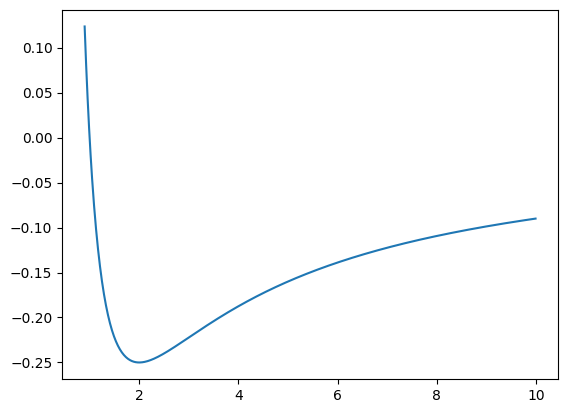

In [13]:
import matplotlib.pyplot as plt
import numpy as np

xx = np.arange(1-0.1, 10,0.01)  
yy = 1/(xx**2)-1/xx

plt.plot(xx, yy)
plt.show()


# MD wikipedia
https://en.wikipedia.org/wiki/Molecular_dynamics
$$
K = n k_{B} \frac{T}{2}
.
$$ 
n is deg of freedom <br>
k is Boltzmann constant

# Reflection image
![reflection img](reflection_img.jpg)

In [3]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange

@dataclass
class Simulation_constants:
    """Holds simulation constants"""
    m: float = 39.9748 # g/mol , mass
    T: float = 300 # K , T
    sigma: float = 3.4 # A, particle size
    eps: float = 0.24 # kcal/mol interactions_strength
    # A box defined by 2 corners (xi,yi), (xf,yf)
    xi: float = 0 # A
    yi: float = 0 # A
    xf: float = 20 # A
    yf: float = 20 # A
    a_unit_factor_kcal_per_gA_to_A_per_ps2: float = 418.4 # A/(ps^2)/ (kcal/(g A)) 
    kB: float = 1.381e-23 # J/K
    kin_to_j: float = 1.661e-23 # J/( g * Å^2 / (ps^2 * mol) )
    kin_to_pot: float = 0.00239 # g *Å^2/(ps^2 * mol) to kcal/mol


class MD_simulation(ABC):
    def __init__(self,sim_cons,pos_file="intial_pos.csv",vel_file="intial_vel.csv"):
        self.positions = torch.from_numpy(np.genfromtxt(pos_file)) # A, 2D (p(article),c(ordinate))
        self.velocities  = torch.from_numpy(np.genfromtxt(vel_file)) # A/ps, like pos 
        self.accelerations = torch.zeros_like(self.positions) # A/ps^2 to be defined, like pos 
        self.constants = sim_cons
        self.total_steps = 0  
        self.total_reflections = 0

        if self.positions.shape != self.velocities.shape:
            raise ValueError("Positions and velocities must have the same shape")

    @abstractmethod   
    def get_potential_energy(self):
        """Calculates the potential energy."""
        pass

    def get_kinetic_energy(self,debug =False):
        """Calculates the kinetic energy, 0.5*sum(m v**2)."""
        v2 = torch.einsum( "p c , p c -> p", self.velocities, self.velocities) # A^2/ps^2
        if debug:
            print(f"v2: \n {v2.detach().numpy()}")
        return 0.5*self.constants.m*torch.einsum("p ->", v2) # g A^2/(ps^2 mol)
    
    def get_kinetic_energy_mol(self):
        return self.constants.kin_to_pot*self.get_kinetic_energy()

    def get_instantaneous_temperature(self):
        # not sure on the dof do we count velocities
        return self.constants.kin_to_j*2*self.get_kinetic_energy()/(self.constants.kB*np.prod(self.positions.shape)) #K

    def get_force(self):
        """Calculates the force as the negative gradient of the potential energy."""
        positions = self.positions.detach().requires_grad_(True)
        energy = self.get_potential_energy(positions) 
        forces, = torch.autograd.grad(energy, positions)
        return -forces

    def get_acceleration(self):
        """F = ma and unit stuff."""
        a = self.get_force()/self.constants.m #kcal/(mol * A * (g/mol)) = kcal/(g *A) = 418.4 A/(ps^2)
        return a * self.constants.a_unit_factor_kcal_per_gA_to_A_per_ps2

    @abstractmethod   
    def step(self):
        """Performs a single step of the simulation."""
        pass


    def step_reflect(self, debug=False, reflect_log=False):
        """Reflects particles that have crossed the boundary."""

        # see img, calculating diff between points and corners by adding corner dim to broadcast 
        diff_to_axis = rearrange(self.positions, "p c -> 1 p c") - torch.tensor([
            [[self.constants.xi, self.constants.yi]], # corner 0
            [[self.constants.xf, self.constants.yf]]  # corner 1
        ]) # A

        # figures out that the point is at correct side of the corner
        diff_to_axis[0,:,:] = torch.min(diff_to_axis[0,:,:], torch.tensor([0]))
        diff_to_axis[1,:,:] = torch.max(diff_to_axis[1,:,:], torch.tensor([0]))

        # the adjustment is - diff *2 and are exclusive so can be summed
        pos_adj = - 2 * torch.einsum("h p c -> p c", diff_to_axis)

        # where an adjustment happens the velocity gets multiplied by -1
        vel_adj = torch.where(torch.abs(pos_adj) > 0, -1, 1)

        adj = torch.einsum("p c -> p", torch.abs(pos_adj))
        amount_reflections = torch.einsum("p->", torch.where(adj > 0, 1, 0))

        self.total_reflections += int(amount_reflections)

        if reflect_log:
            if amount_reflections>0:
                print(f"amount of reflections: {amount_reflections}")

        if debug:
            print("Debug Information: Reflect Step")
            print("-" * 40)  # Separator for better readability
            print("Current Boundary Corners:")
            print(f"Bottom Left Corner: ({self.constants.xi}, {self.constants.yi})")
            print(f"Top Right Corner: ({self.constants.xf}, {self.constants.yf})")
            print("\nPosition Adjustments (pos_adj):")
            print(pos_adj)
            print("\nVelocity Adjustments (vel_adj):")
            print(vel_adj)
            print("-" * 40)  # Separator for clarity
            self.plt_points()

        # update positions and velocities
        self.positions = self.positions + pos_adj
        self.velocities = self.velocities * vel_adj

        if debug:
            self.plt_points()


    def plt_points(self):
        """Try it to see what is does, LLMs are great at writing plots."""
        pos = self.positions.detach().numpy()  
        vel = self.velocities.detach().numpy()  
        acc = self.accelerations.detach().numpy() 

        plt.scatter(pos[:, 0], pos[:, 1], color='blue', label='Particles')  # Scatter plot for the points

        # Annotate each point with an identifier (e.g., index)
        for i, (x, y) in enumerate(pos):
            plt.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(5, 5), ha='center')

            # Add arrows for velocities
            plt.arrow(x, y, vel[i, 0], vel[i, 1],
                    head_width=0.1, head_length=0.2,
                    fc='red', ec='red',
                    length_includes_head=True)  # Draw velocity vectors as arrows

            # Add arrows for accelerations
            plt.arrow(x, y, acc[i, 0], acc[i, 1],
                    head_width=0.1, head_length=0.2,
                    fc='green', ec='green',
                    length_includes_head=True)  # Draw acceleration vectors as arrows

        # Draw the box
        box_x = [self.constants.xi, self.constants.xf, self.constants.xf, self.constants.xi, self.constants.xi]
        box_y = [self.constants.yi, self.constants.yi, self.constants.yf, self.constants.yf, self.constants.yi]
        plt.plot(box_x, box_y, color='black', linestyle='--', label='Box')  # Draw the box

        # Create dummy artists for velocity and acceleration arrows in the legend
        plt.plot([], [], color='red', marker='o', linestyle='-', label='Velocities')
        plt.plot([], [], color='green', marker='o', linestyle='-', label='Accelerations')

        # Labels and limits
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.xlim(self.constants.xi - 5, self.constants.xf + 5)
        plt.ylim(self.constants.yi - 5, self.constants.yf + 5)
        plt.grid(True)
        plt.legend(loc="upper right")  # Add legend to distinguish the particles and boundary box
        plt.title('Particle Positions with Velocities and Accelerations')
        plt.show()


class MD_simulation_lj_vv(MD_simulation):
    """Implements the Lennard-Jones potential and Velocity Verlet integration step"""

    def __init__(self,sim_cons,pos_file="initial_pos.csv",vel_file="initial_vel.csv"):
        MD_simulation.__init__(self,sim_cons,pos_file,vel_file)
        self.accelerations = self.get_acceleration()

    def get_potential_energy(self,positions, debug=False):
        """Calculates Lennard-Jones potential."""

        distances = torch.cdist(positions, positions, p=2) # A^2

        # Create a mask for the upper triangle (excluding the diagonal)
        mask = torch.triu(torch.ones_like(distances), diagonal=1).bool()

        # Apply the calculation only to the masked elements
        tmp = torch.zeros_like(distances)  # Initialize tmp
        tmp[mask] = self.constants.sigma**6 / distances[mask]**6 #dimensionless
        tmp = 4 * self.constants.eps * tmp * (tmp - 1)  # kcal/mol

        return torch.einsum("ij->", tmp)  # kcal/mol

    def step(self,dt,reflect_log=False):
        """Implements Velocity Verlet integration step combined with reflection."""
        #order matters
        self.positions = self.positions + self.velocities*dt + 0.5*self.accelerations*dt**2
        self.step_reflect(reflect_log=reflect_log)
        new_a = self.get_acceleration() 
        self.velocities = self.velocities + 0.5*(self.accelerations+new_a)*dt
        self.accelerations = new_a
        self.total_steps +=1



class MD_simulation_gravity_vv(MD_simulation):
    """Implements the gravity potential and Velocity Verlet integration step."""

    def __init__(self,sim_cons,pos_file="initial_pos.csv",vel_file="initial_vel.csv"):
        MD_simulation.__init__(self,sim_cons,pos_file,vel_file)
        self.accelerations = self.get_acceleration()


    def get_potential_energy(self, positions):
        """
        Calculates potential energy for constant force (e.g. gravity): U = mgh
        Assumes force points in negative y direction (gravity)
        """
        g = 1/100   # work nicely with the example 
        return self.constants.m * g * torch.einsum("p -> ", positions[:,1])  


    def step(self,dt,reflect_log=False):
        """Implements Velocity Verlet integration step combined with reflection."""
        #order matters
        self.positions = self.positions + self.velocities*dt + 0.5*self.accelerations*dt**2
        self.step_reflect(reflect_log=reflect_log)
        new_a = self.get_acceleration() 
        self.velocities = self.velocities + 0.5*(self.accelerations+new_a)*dt
        self.accelerations = new_a
        self.total_steps +=1

class MD_simulation_gravity_lj_vv(MD_simulation):
    """Implements the gravity potential and Velocity Verlet integration step."""

    def __init__(self,sim_cons,pos_file="initial_pos.csv",vel_file="initial_vel.csv"):
        MD_simulation.__init__(self,sim_cons,pos_file,vel_file)
        self.accelerations = self.get_acceleration()


    def get_potential_energy_gravity(self, positions):
        """
        Calculates potential energy for constant force (e.g. gravity): U = mgh
        Assumes force points in negative y direction (gravity)
        """
        g = 1/100   # work nicely with the example 
        return self.constants.m * g * torch.einsum("p -> ", positions[:,1])  

    
    def get_potential_energy_lj(self,positions, debug=False):
        """Calculates Lennard-Jones potential."""

        distances = torch.cdist(positions, positions, p=2) # A^2

        # Create a mask for the upper triangle (excluding the diagonal)
        mask = torch.triu(torch.ones_like(distances), diagonal=1).bool()

        # Apply the calculation only to the masked elements
        tmp = torch.zeros_like(distances)  # Initialize tmp
        tmp[mask] = self.constants.sigma**6 / distances[mask]**6 #dimensionless
        tmp = 4 * self.constants.eps * tmp * (tmp - 1)  # kcal/mol

        return torch.einsum("ij->", tmp)  # kcal/mol
    
    def get_potential_energy(self,position):
        return self.get_potential_energy_gravity(position)+ self.get_potential_energy_lj(position) 

    def step(self,dt,reflect_log=False):
        """Implements Velocity Verlet integration step combined with reflection."""
        #order matters
        self.positions = self.positions + self.velocities*dt + 0.5*self.accelerations*dt**2
        self.step_reflect(reflect_log=reflect_log)
        new_a = self.get_acceleration() 
        self.velocities = self.velocities + 0.5*(self.accelerations+new_a)*dt
        self.accelerations = new_a
        self.total_steps +=1



# Testing reflection

amount of reflections: 7
Debug Information: Reflect Step
----------------------------------------
Current Boundary Corners:
Bottom Left Corner: (0, 0)
Top Right Corner: (20, 20)

Position Adjustments (pos_adj):
tensor([[-6.4200, -7.3800],
        [ 6.4200,  7.3800],
        [-6.4200, -0.0000],
        [-6.4200,  7.3800],
        [ 6.4200, -7.3800],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000,  5.2200],
        [-0.0000, -7.2200]], dtype=torch.float64)

Velocity Adjustments (vel_adj):
tensor([[-1, -1],
        [-1, -1],
        [-1,  1],
        [-1, -1],
        [-1, -1],
        [ 1,  1],
        [ 1,  1],
        [ 1,  1],
        [ 1,  1],
        [ 1, -1],
        [ 1, -1]])
----------------------------------------


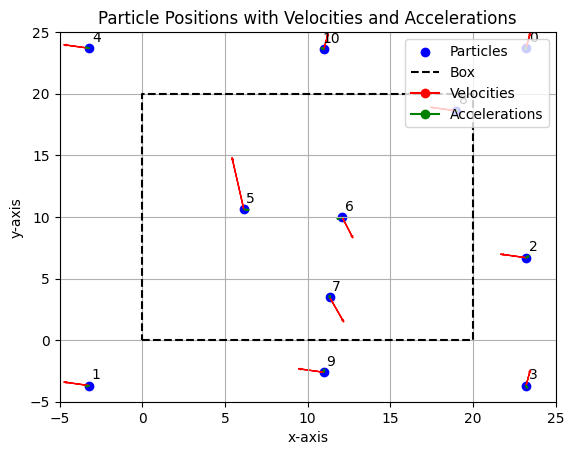

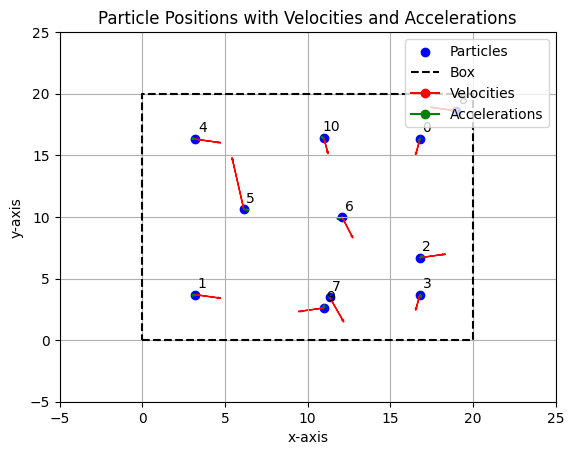

In [4]:
def test_reflection():
    sim_cons = Simulation_constants()
    sim_lj = MD_simulation_lj_vv(
        sim_cons=sim_cons,
        pos_file="./test_init/reflect_pos.csv",
        vel_file="./test_init/reflect_vel.csv"
        )
    sim_lj.step_reflect(debug=True,reflect_log=True)

test_reflection()

# Testing Force, Potential 

potential: -2.53
v2: 
 [ 1.706   2.4866 18.4113  3.2786  4.82    5.9648  8.3641 15.9826 21.0697
 13.505  18.8548 11.2264 19.3465 16.3906 13.0513 12.164 ]
kinetic: 3730.09
instantaneous_temperature: 280.40
position:
        0      1
0   18.21   6.69
1   18.98  18.61
2    2.11  13.90
3    4.85   3.55
4    6.14  10.61
5   12.09   9.97
6   11.33   3.48
7   12.71  17.73
8   10.21  14.26
9    0.05   2.74
10  15.66  14.74
11   6.58  17.66
12  14.70   1.21
13   8.20   6.25
14  19.03  11.29
15   2.06   7.83
force:
       0     1
0  -0.00  0.12
1  -0.08 -0.07
2   0.09 -0.05
3   0.00  0.17
4  -0.02 -0.08
5  -0.09  0.09
6  -0.01  0.05
7   0.01 -0.26
8   0.09  0.05
9   0.13  0.07
10 -0.06  0.07
11  0.07 -0.10
12 -0.12  0.10
13 -0.03 -0.07
14 -0.11 -0.04
15  0.13 -0.04


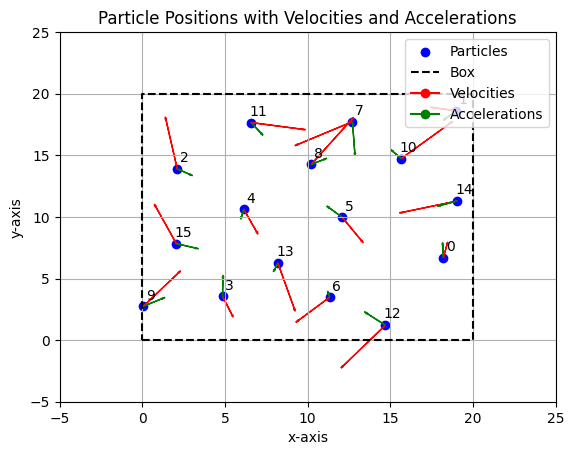

In [5]:
import pandas as pd
def test_force_etc():
    sim_cons = Simulation_constants()
    sim_lj = MD_simulation_lj_vv(sim_cons, pos_file="./test_init/simple_pos.csv",vel_file="./test_init/simple_vel.csv")
    sim_lj = MD_simulation_lj_vv(sim_cons)
    print(f"potential: {sim_lj.get_potential_energy(positions=sim_lj.positions,debug=True).detach().numpy():0.2f}")
    print(f"kinetic: {sim_lj.get_kinetic_energy(debug=True).detach().numpy():0.2f}")
    print(f"instantaneous_temperature: {sim_lj.get_instantaneous_temperature().detach().numpy():0.2f}")
    print(f"position:\n{pd.DataFrame(sim_lj.positions.detach().numpy()).round(2)}")
    print(f"force:\n{pd.DataFrame(sim_lj.get_force().detach().numpy()).round(2)}")
    sim_lj.plt_points()

test_force_etc()

In [6]:
import pandas as pd
def test_force2():
    sim_cons = Simulation_constants()
    sim_lj = MD_simulation_lj_vv(sim_cons)
    print(f"potential: {sim_lj.get_potential_energy(sim_lj.positions).detach().numpy():0.2f}")
    print(f"force:\n{pd.DataFrame(sim_lj.get_force().detach().numpy()).round(3)}")

    sim_gravity = MD_simulation_gravity_vv(sim_cons)
    print(f"potential: {sim_gravity.get_potential_energy(sim_gravity.positions).detach().numpy():0.2f}")
    print(f"force:\n{pd.DataFrame(sim_gravity.get_force().detach().numpy()).round(3)}")

test_force2()

potential: -2.53
force:
        0      1
0  -0.004  0.118
1  -0.075 -0.074
2   0.089 -0.052
3   0.003  0.165
4  -0.018 -0.077
5  -0.090  0.088
6  -0.012  0.049
7   0.015 -0.262
8   0.092  0.048
9   0.127  0.069
10 -0.061  0.070
11  0.069 -0.099
12 -0.121  0.104
13 -0.026 -0.068
14 -0.113 -0.041
15  0.128 -0.039
potential: 64.17
force:
      0    1
0  -0.0 -0.4
1  -0.0 -0.4
2  -0.0 -0.4
3  -0.0 -0.4
4  -0.0 -0.4
5  -0.0 -0.4
6  -0.0 -0.4
7  -0.0 -0.4
8  -0.0 -0.4
9  -0.0 -0.4
10 -0.0 -0.4
11 -0.0 -0.4
12 -0.0 -0.4
13 -0.0 -0.4
14 -0.0 -0.4
15 -0.0 -0.4


# Testing lj_vv simulation

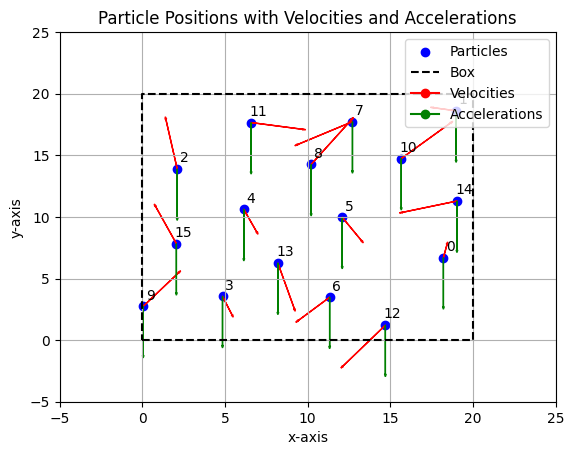

100


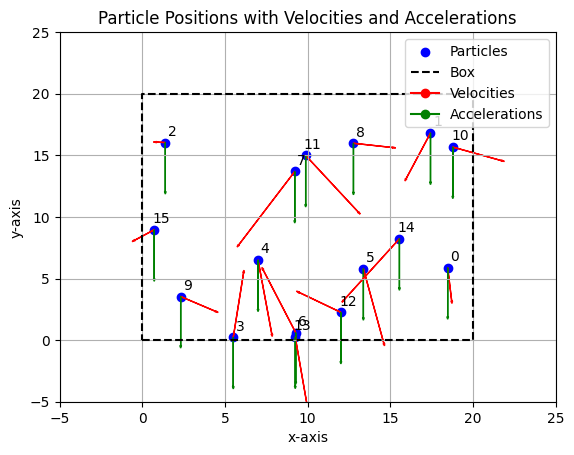

200


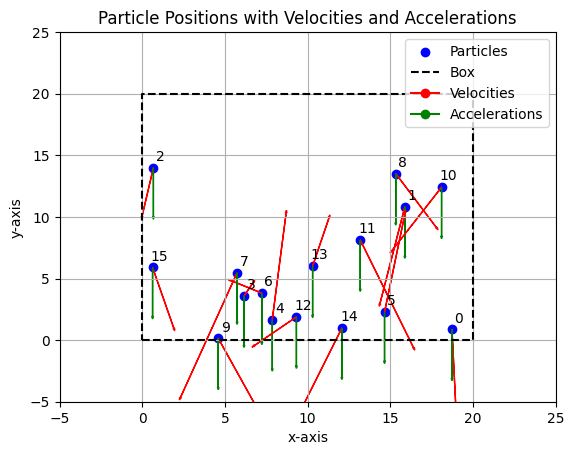

300


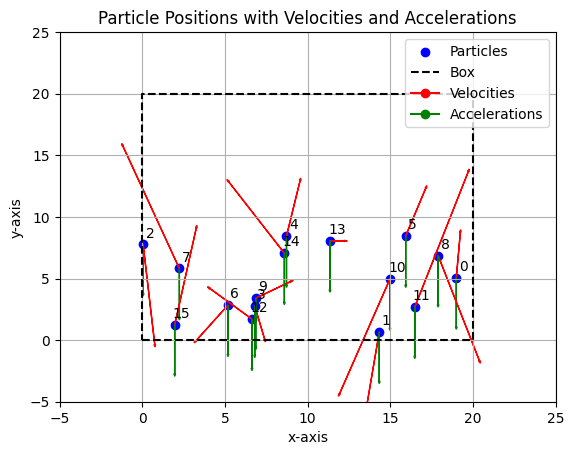

400


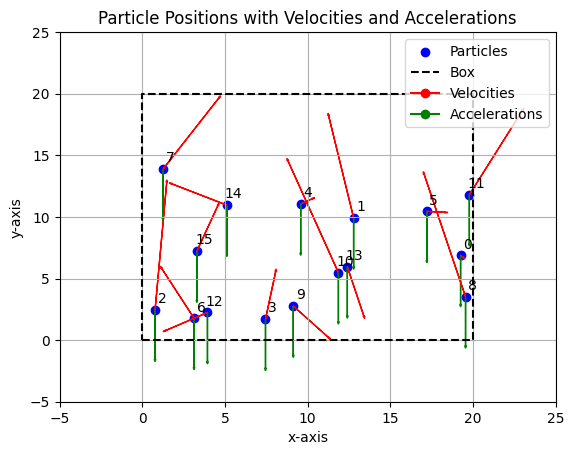

In [8]:
def test_sim_step(sim):
    sim.plt_points()
    for _ in range(400):
        sim.step(dt=0.01)
        if sim.total_steps%100 == 0:
            print(sim.total_steps)
            sim.plt_points()

sim_cons = Simulation_constants()
sim = MD_simulation_lj_vv(sim_cons)
sim = MD_simulation_gravity_vv(sim_cons)
test_sim_step(sim)
# test_sim_step(sim_lj)

# Choosing dt
I estimate integration error by comparing to a finer simulation, in that way I estimate the size of contribution to the truncation error/ step of the integrator.

In [9]:
import pandas as pd

def get_convergence_error(dt):
    sim_cons = Simulation_constants()
    sim_coarse = MD_simulation_lj_vv(sim_cons) 
    sim_coarse.step(dt=dt)
    sim_fine = MD_simulation_lj_vv(sim_cons) 
    for _ in range(10):
        sim_fine.step(dt=dt/10,reflect_log=True)
    error_per_step = (torch.abs(sim_fine.positions-sim_coarse.positions) 
        + torch.abs(sim_fine.velocities-sim_coarse.velocities))/dt
    print(f"dt:{dt}, estimate pos_error_per_step :\n{pd.DataFrame(error_per_step.detach().numpy()).round(5)}")

for dt in [0.5,0.25,0.1,0.01,0.005]:
    get_convergence_error(dt)

amount of reflections: 1
dt:0.5, estimate pos_error_per_step :
               0             1
0   1.625150e+00  4.291770e+00
1   3.201854e+02  7.693275e+02
2   2.018400e-01  1.418100e-01
3   4.567200e-01  5.514500e-01
4   4.877000e-02  1.774400e-01
5   2.832100e-01  3.130400e-01
6   1.657751e+03  1.742683e+03
7   3.565776e+10  1.051548e+10
8   3.565776e+10  1.051548e+10
9   3.427900e-01  6.071000e-02
10  3.201330e+02  7.691914e+02
11  1.958752e+02  6.042574e+01
12  5.867630e+00  5.627810e+00
13  1.652631e+03  1.738600e+03
14  1.832470e+00  3.901830e+00
15  3.297000e-02  1.745600e-01
dt:0.25, estimate pos_error_per_step :
             0           1
0      0.04692     0.31814
1      0.58033     0.78996
2      0.08120     0.06032
3      0.06746     0.06698
4      0.01972     0.07945
5      0.03941     0.12972
6      9.66614     9.36517
7   2852.35803  5722.82084
8   2852.71174  5722.79462
9      0.06626     0.03011
10     0.53953     0.75436
11     0.26357     0.10528
12     0.00969     0

# Experiment

In [10]:
from tqdm import tqdm

def experiment(dt=0.01,total_steps=10000, record_interval = 100):
    sim_cons = Simulation_constants()
    sim = MD_simulation_lj_vv(sim_cons)
    # sim = MD_simulation_gravity_lj_vv(sim_cons)
    
    Upot_in_time = []
    K_in_time = []
    iT_in_time = []
    pos_in_time = []
    vel_in_time = []
    acc_in_time = []
    refl_in_time = []
    
    def record_state():
        Upot_in_time.append(sim.get_potential_energy(sim.positions))
        K_in_time.append(sim.get_kinetic_energy_mol())
        iT_in_time.append(sim.get_instantaneous_temperature())
        refl_in_time.append(sim.total_reflections)
        pos_in_time.append(sim.positions)
        vel_in_time.append(sim.velocities)
        acc_in_time.append(sim.accelerations)
    
    record_state()  
    
    for _ in tqdm(range(total_steps),desc="running experiment"):
        sim.step(dt=dt)
        if sim.total_steps % record_interval == 0:
            record_state()  
            
    return {
        "potential_energy": np.array(Upot_in_time),
        "kinetic_energy": np.array(K_in_time),
        "temperature": np.array(iT_in_time),
        "reflections": np.array(refl_in_time),
        "positions": pos_in_time,
        "velocities": vel_in_time,
        "accelerations": acc_in_time
    }

result = experiment(dt=0.005, total_steps=10**4, record_interval= 20)

running experiment:   0%|          | 0/10000 [00:00<?, ?it/s]

running experiment: 100%|██████████| 10000/10000 [00:14<00:00, 680.80it/s]


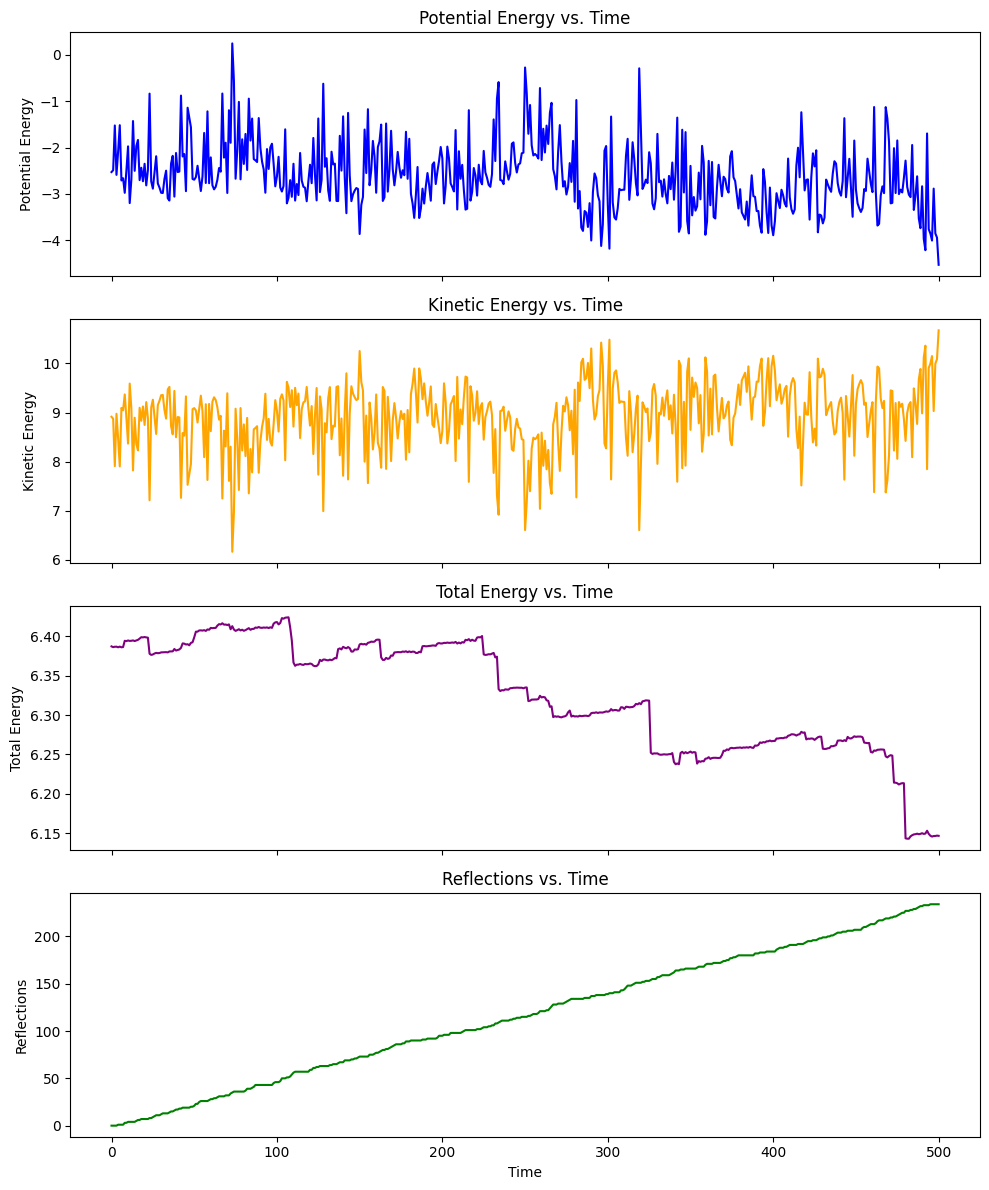

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plt_result_time_arrays(result):
    # Calculate total energy
    total_energy = result["potential_energy"] + result["kinetic_energy"]

    # Create a time array assuming one entry per time step
    time = np.arange(len(result["potential_energy"]))

    # Set up the figure and subplots with 4 rows, sharing the x-axis
    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1]})

    # Plot potential energy on the first subplot
    axs[0].plot(time, result["potential_energy"], color="blue")
    axs[0].set_ylabel("Potential Energy")
    axs[0].set_title("Potential Energy vs. Time")

    # Plot kinetic energy on the second subplot
    axs[1].plot(time, result["kinetic_energy"], color="orange")
    axs[1].set_ylabel("Kinetic Energy")
    axs[1].set_title("Kinetic Energy vs. Time")

    # Plot total energy on the third subplot
    axs[2].plot(time, total_energy, color="purple")
    axs[2].set_ylabel("Total Energy")
    axs[2].set_title("Total Energy vs. Time")

    # Plot reflections on the fourth subplot
    axs[3].plot(time, result["reflections"], color="green")
    axs[3].set_xlabel("Time")
    axs[3].set_ylabel("Reflections")
    axs[3].set_title("Reflections vs. Time")

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

plt_result_time_arrays(result)


In [12]:
from ipywidgets import interactive, IntSlider
from IPython.display import display

def plt_interactive(result: dict) -> None:
    sim_cons = Simulation_constants()
    sim = MD_simulation_lj_vv(sim_cons) 

    # Function to update the plot based on the slider value
    def plot_qq(i: int) -> None:
        sim.positions = result["positions"][i]
        sim.velocities = result["velocities"][i]
        sim.accelerations = result["accelerations"][i]
        sim.plt_points()

    # Create a slider for iterations based on the length of positions
    i_slider = IntSlider(
        value=0,
        min=0,
        max=len(result["positions"]) - 1,  # Dynamic max based on data length
        description='Iterations'
    )
    
    # Create an interactive plot
    interactive_plot = interactive(plot_qq, i=i_slider)
    display(interactive_plot)

# Example call
plt_interactive(result)


interactive(children=(IntSlider(value=0, description='Iterations', max=500), Output()), _dom_classes=('widget-…